In [1]:
import pandas as pd
import os
import json
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report, accuracy_score

In [2]:
# Data Prep

In [3]:
data_base_pth = "/blue/cap4773/tej/baseline/data/raw_rdd/ds0"
annotation_base = os.path.join(data_base_pth, "ann")
images_base = os.path.join(data_base_pth, "img")

In [4]:
image_class_map = {}
classes = set()  # Initialize an empty set to store all unique class names

# Loop through all annotations (JSON files)
for annotation in os.listdir(annotation_base):
    if annotation.endswith(".json"):
        annotation_path = os.path.join(annotation_base, annotation)

        with open(annotation_path, "r") as file:
            annotation_data = json.load(file)

            base_filename = os.path.splitext(annotation)[0]
            image_classes = []

            # Extract classes from the "objects" field in the JSON
            for obj in annotation_data.get("objects", []):
                class_title = obj["classTitle"]
                image_classes.append(class_title)
                classes.add(class_title)  # Add class to the set (ensures uniqueness)

            # Construct the image path
            image_path = os.path.join(images_base, base_filename)  # Adjust extension if needed
            if os.path.exists(image_path):
                image_class_map[image_path] = image_classes


In [5]:
classes = sorted(list(classes))  # Now `classes` contains all unique class names

# Map each class to an index
class_to_index = {class_name: i for i, class_name in enumerate(classes)}

# Convert image labels to a binary multi-label matrix
image_paths = list(image_class_map.keys())
image_labels = list(image_class_map.values())

In [6]:
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    # Read the image from file
    img = cv2.imread(image_path)
    
    # Check if the image is loaded correctly
    if img is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")
    
    # Resize the image to the target size
    img_resized = cv2.resize(img, target_size)
    
    # Normalize the pixel values (convert to float and divide by 255)
    img_normalized = img_resized / 255.0
    
    return img_normalized

In [7]:
multi_label_matrix = []
for labels in image_labels:
    binary_vector = [0] * len(classes)
    for label in labels:
        binary_vector[class_to_index[label]] = 1
    multi_label_matrix.append(binary_vector)

multi_label_matrix = np.array(multi_label_matrix)

In [8]:
images_data = []

for image_path in image_paths:
    img = load_and_preprocess_image(image_path)  # Load and preprocess the image
    images_data.append(img)

images_data = np.array(images_data)
train_X, test_X, train_Y, test_Y = train_test_split(images_data, multi_label_matrix, test_size=0.2, random_state=42)

In [9]:
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(2656, 128, 128, 3)
(2656, 4)
(665, 128, 128, 3)
(665, 4)


In [10]:
def build_multilabel_classifier(input_shape=(128, 128, 3), num_classes=3):
    model = Sequential()

    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Output Layer: One neuron per class with sigmoid activation for multi-label classification
    model.add(Dense(num_classes, activation='sigmoid'))

    # Compile the model with binary_crossentropy for multi-label classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create the model for multi-class, multi-label classification
num_classes = len(classes)  # For example, if you have 3 types of cracks
multilabel_model = build_multilabel_classifier(num_classes=num_classes)

# Summary of the model
multilabel_model.summary()

2024-09-24 13:16:00.655472: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-24 13:16:01.348205: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78902 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       2

In [11]:
# Define the number of epochs and batch size
epochs = 25  # You can adjust this number based on your dataset and performance
batch_size = 32  # Adjust based on available memory and hardware

# Train the model
history = multilabel_model.fit(
    train_X,              # Training images (NumPy array of preprocessed images)
    train_Y,              # Multi-label binary vectors for each image
    epochs=epochs,        # Number of epochs to train
    batch_size=batch_size,  # Batch size (tune according to hardware capacity)
    validation_data=(test_X, test_Y),  # Validation data (to monitor model performance)
    verbose=1             # Set verbose to 1 to see progress during training
)

Epoch 1/25


2024-09-24 13:16:05.029399: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2024-09-24 13:16:06.689021: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


83/83 [==============================] - 5s 13ms/step - loss: 0.8526 - accuracy: 0.3291 - val_loss: 2.2672 - val_accuracy: 0.2511
Epoch 2/25
83/83 [==============================] - 1s 9ms/step - loss: 0.7245 - accuracy: 0.3656 - val_loss: 2.0939 - val_accuracy: 0.2602
Epoch 3/25
83/83 [==============================] - 1s 12ms/step - loss: 0.6473 - accuracy: 0.4010 - val_loss: 2.7321 - val_accuracy: 0.2797
Epoch 4/25
83/83 [==============================] - 1s 11ms/step - loss: 0.6084 - accuracy: 0.4217 - val_loss: 1.4497 - val_accuracy: 0.2511
Epoch 5/25
83/83 [==============================] - 1s 12ms/step - loss: 0.5730 - accuracy: 0.4582 - val_loss: 1.0410 - val_accuracy: 0.2481
Epoch 6/25
83/83 [==============================] - 1s 11ms/step - loss: 0.5349 - accuracy: 0.4902 - val_loss: 0.8483 - val_accuracy: 0.3910
Epoch 7/25
83/83 [==============================] - 1s 13ms/step - loss: 0.5269 - accuracy: 0.5008 - val_loss: 0.7100 - val_accuracy: 0.3774
Epoch 8/25
83/83 [=======

In [18]:
predictions = multilabel_model.predict(test_X)

# Apply a threshold (e.g., 0.5) to convert probabilities to binary labels (multi-label)
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Choose a random index from the test set
random_index = np.random.randint(0, len(test_X))

# Get the true and predicted labels for the chosen index
true_labels = test_Y[random_index]
predicted_labels_for_example = predicted_labels[random_index]

# Print out the results
print(f"Example {random_index}:")
print(f"True labels (binary vector): {true_labels}")
print(f"Predicted labels (binary vector): {predicted_labels_for_example}")

Example 53:
True labels (binary vector): [1 1 1 0]
Predicted labels (binary vector): [1 1 1 0]


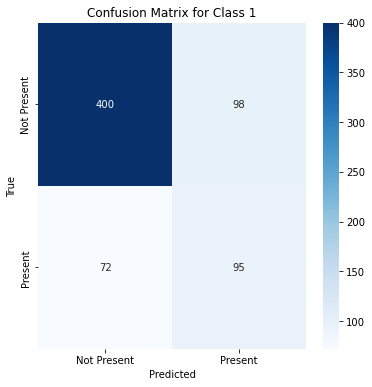

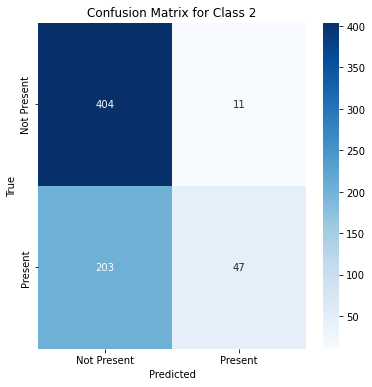

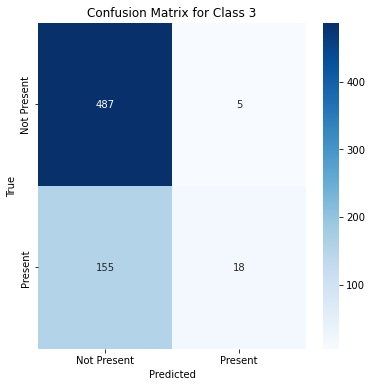

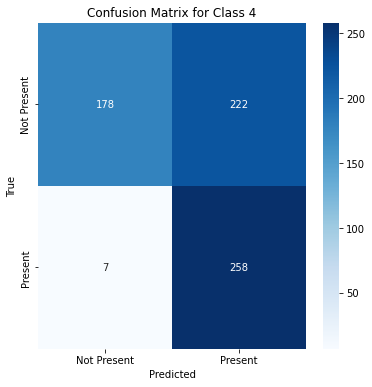

In [13]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set the threshold for binarizing predictions
threshold = 0.5

# Make predictions on the test set
predictions = multilabel_model.predict(test_X)

# Binarize predictions
binary_predictions = (predictions > threshold).astype(int)

# Compute confusion matrix
conf_matrix = multilabel_confusion_matrix(test_Y, binary_predictions)

# Function to plot confusion matrices
def plot_confusion_matrices(conf_matrix, classes, max_classes=10):
    num_classes = len(classes)
    if num_classes > max_classes:
        print(f"Displaying only the first {max_classes} classes.")
    
    for i in range(min(num_classes, max_classes)):
        plt.figure(figsize=(6, 6))
        sns.heatmap(conf_matrix[i], annot=True, fmt='d', cmap='Blues', 
                     xticklabels=['Not Present', 'Present'], 
                     yticklabels=['Not Present', 'Present'])
        plt.title(f'Confusion Matrix for {classes[i]}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

# Define your class names (modify this according to your actual class names)
classes = [f'Class {i+1}' for i in range(num_classes)]  # Update based on your actual classes

# Plot confusion matrices for a maximum of 10 classes
plot_confusion_matrices(conf_matrix, classes, max_classes=10)

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming binary_predictions and test_Y are already defined
# For multi-label, set average='macro' for unweighted mean, or 'micro' for aggregated metrics
precision = precision_score(test_Y, binary_predictions, average='macro')
recall = recall_score(test_Y, binary_predictions, average='macro')
f1 = f1_score(test_Y, binary_predictions, average='macro')

# Print the results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Precision: 0.6557
Recall: 0.4586
F1 Score: 0.4273


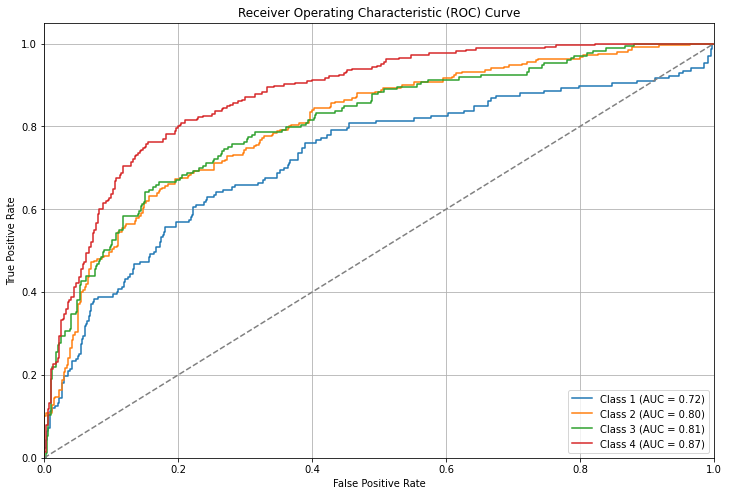

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming predictions and test_Y are already defined
# Get the predicted probabilities
predictions = multilabel_model.predict(test_X)

# Number of classes
num_classes = test_Y.shape[1]

# Set up the plot
plt.figure(figsize=(12, 8))

# Compute ROC curve and ROC area for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(test_Y[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'Class {i + 1} (AUC = {roc_auc:.2f})')

# Plotting the diagonal line (chance level)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Plot details
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()